# Replication of Carneiro, Heckman, & Vytlacil's (2011) *Local Instrumental Variables* approach

In this notebook, we reproduce the semiparametric results from

Carneiro, P., Heckman, J. J., & Vytlacil, E. J. (2011). [Estimating marginal returns to education.](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754) *American Economic Review, 101*(6), 2754-81. 

The goal of this endeavor is to add the semiparametric estimation method to the open-source package *grmpy* for the simulation and estimation of the generalized Roy model in Python. Currently, *grmpy* is limited to the estimation of a parametric normal version of the generalized Roy model. <br> For more, see the [online documentation](https://grmpy.readthedocs.io/en/develop/). 

This notebook makes use of the replication material provided by [Carneiro et al. (2011)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754).

### Preliminaries

Import some libraries we need in the replication process. 

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm
import pandas as pd
import numpy as np

import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib import pyplot

We also need to import the *rpy2 interface* along with R's KernSmooth package. We will utilize the function *locpoly* to fit a local quadratic regression later on.

In [2]:
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr
import rpy2.rinterface

KernSmooth = rpackages.importr('KernSmooth')

# The Generalized Roy Model

\begin{align*}
 &\textbf{Potential Outcomes} & & \textbf{Choice}  &\\
 & Y_1 = \beta_1 X + U_{1} &  &D_i = \mathbf{1}\{\Phi(\gamma Z) > u_D\} &\\
 & Y_0 = \beta_0 X + U_{0} &  & \text{with $u_D = \Phi(V)$}  &\\
&&&&\\
& \textbf{Observed Outcome} &&&\\
& Y = D Y_1 + (1-D) Y_0 &&&
\end{align*}

$Y_1$ and $Y_0$ are the potential outcomes in the treated and untreated state, such as log wages with and without a college degree. They are modeled as functions of observables $X$ (regressors) and unobservables $U_1$ and $U_1$.
In the choice equation, $Z$ and $V$ represent observables and unobservables respectively, where
$V$ can be interpreted as the unobserved resistance to treatment.

Note that in the semiparametric setup we do not make any assumptions about the distributional characteristics (such as joint normality) of the unobservable terms $\{U_1, U_0, V\}$. 

However, Carneiro et al. (2011) invoke the assumption that $(X,Z)$ is independent of $\{U_1, U_0, V\}$. Under this assumption, the *MTE* 

1) is additively separable in $X$ and $U_D$, which means that the shape of the *MTE* is independent of $X$, 

2) and is identified over the common support of $P(Z)$, unconditional on $X$. 

Define $U_S = F_V(V)$, where $F_V ()$ is the cumulative distribution function of $V$. Thus, $U_D$ represents the quantiles of $V$. $P(Z)$ denotes the probability of going to college ($D=1$) and will be henceforth called *propensity score*.

The marginal treatment effect (*MTE*) in the generalized Roy model is $E(Y_1 − Y_0 | X = x, V = v)$ or equivalently $E(Y_1−Y_0|X = x, U_D = u_D)$. <br>
*MTEs* measure average gains in outcomes for people with particular values of $X$ and the unobserved resistance to treatment $U_D$. Alternatively, the MTE can be interpreted as the mean return to treatment for individuals at a particular margin of indifference.

# The *LIV* Framework

We follow the steps outlined in Carneiro et al. (2011) and [Heckman, Urzua, & Vytlacil (2006)](http://jenni.uchicago.edu/underiv/documentation_2006_03_20.pdf) in constructing the *Local Instrumental Variable* (LIV) estimator.
Caneiro et al. (2011) work with the following linear-in-the-parameters version of the generalized Roy model:

$$E(Y|X = x, P(Z) = p) =  x \beta_0 + p x (\beta_1 - \beta_0) + K(p) \ \ \ \mathrm{(1)}$$

where they estimate $K(p) = E(U_1 - U_0 | S = 1, P(Z) = p)$ nonparametrically. $K(p$) is a nonlinear function of $p$ that captures heterogeneity along the unobservable resistance to treatment $u_D$.

This expression indicates that in general the computation of the MTE involves the estimation of the partial derivative of the expectation of the outcome $Y$ (conditional on $X = x$ and $P(Z) = p$) with respect to $p$. This is the method of local instrumental variables introduced in Heckman and Vytlacil ([2001](https://www.aeaweb.org/articles?id=10.1257/aer.91.2.107)).

Taking the derivative of this expression with respect to $p$ and evaluating it at $u_D,$ we get the *MTE*, as shown by Heckman and Vytlacil ([2001](https://www.aeaweb.org/articles?id=10.1257/aer.91.2.107), [2005](https://www.jstor.org/stable/3598865?seq=1#page_scan_tab_contents)):

$$\Delta^{LIV} (x, u_D) \ = \frac{E(Y|X = x, P(Z) = p)}{\partial p} \ \bigg\rvert_{p = u_D}  =  x' (\beta_1 - \beta_0) + \frac{\partial K(p)}{\partial p} \ \bigg\rvert_{p = u_D} = \ \Delta^{MTE} (x, u_D) \ $$

The columns of $X$ are fixed at their mean values in the sample, denoted by $x$. In order to compute the *MTE* we need to estimate values for $(\beta_1 - \beta_0)$ and $\frac{\partial K}{\partial p}$. Without further assumptions on the structure of the unobservables $\{U_1, U_0, V\}$ this last part needs to be estimated nonparametrically. 

# Replication

### Data Preparation

Since the replication material does not contain geographic identifiers, we are unable to merge the separate data files so that they recreate the original data set. Therefore, we need to create a mock data set where indivudal specific data and local characteristics are merged arbitrarily (note, however, that the basic and local data are merged the same way each time, so we always work with the same mock data set).

The function below adds squared and interaction terms to the Cainero data set and is copied from the *auxiliary.py* file located in the *grmpy* repository on [GitHub](https://github.com/OpenSourceEconomics/grmpy/tree/master/promotion/04_grmpy_tutorial_notebook).

In [3]:
def process_data(df, output_file):
    """This function adds squared and interaction terms to the Carneiro data set."""

    # Delete redundant columns\n",
    for key_ in ["newid", "caseid"]:
        del df[key_]

    # Add squared terms
    for key_ in ["mhgc", "cafqt", "avurate", "lurate_17", "numsibs", "lavlocwage17"]:
        str_ = key_ + "sq"
        df[str_] = df[key_] ** 2

    # Add interaction terms
    for j in ["pub4", "lwage5_17", "lurate_17", "tuit4c"]:
        for i in ["cafqt", "mhgc", "numsibs"]:
            df[j + i] = df[j] * df[i]

In [4]:
basic = pd.read_stata('data/basicvariables.dta')
local = pd.read_stata('data/localvariables.dta') 
df = pd.concat([basic, local], axis = 1)
process_data(df,'data/aer-replication-mock')

## $\mathrm{1)}$ Estimate propensity score $\hat{P}(z)$

The first step in the computation of the *MTE* is to estimate the probability of participation or *propensity score*, $Pr(D = 1|Z = z) = P(z)$. Before we do that, select the observables $Z$ of the choice equation.

In [5]:
Z_df = df[['const',
 'cafqt',
 'cafqtsq',
 'mhgc',
 'mhgcsq',
 'numsibs',
 'numsibssq',
 'urban14',
 'lavlocwage17',
 'lavlocwage17sq',
 'avurate',
 'avuratesq',
 'd57',
 'd58',
 'd59',
 'd60',
 'd61',
 'd62',
 'd63',
 'lwage5_17numsibs',
 'lwage5_17mhgc',
 'lwage5_17cafqt',
 'lwage5_17',
 'lurate_17',
 'lurate_17numsibs',
 'lurate_17mhgc',
 'lurate_17cafqt',
 'tuit4c',
 'tuit4cnumsibs',
 'tuit4cmhgc',
 'tuit4ccafqt',
 'pub4',
 'pub4numsibs',
 'pub4mhgc',
 'pub4cafqt']]

The *'state'* variable denotes state of treatment ($D = 1$ or $D = 0$). As Carneiro et al. (2011), we run a logit regression of $Z$ on $D$. Fitting the choice model with probit produces similar results.

In [6]:
logitRslt = sm.Logit(df['state'], Z_df).fit(disp=0)
ps = logitRslt.predict(Z_df)
#print(logitRslt.summary())

## $\mathrm{2)}$ Plot the support of $\hat{P}(z)$ for $D = 1$ and $D = 0$, find common support and trim the data

The predicted values of the propensity score allow us to define the values of $u_D$ over which the *MTE* can be identified.  Identification of the *MTE* depends critically on the *common support* of the propensity score. Common support is defined as the intersection of the support of $P(z)$ given $D = 1$ and the support of $P(z)$ given $D = 0$. i.e. those evaluations of $P(z)$ for which we obtain positive frequencies for both subsamples. 

After identifying the common support of the propensity score, it is necessary to adjust the sample: Observations for which $\hat{P}(z)$ is contained in the common support are kept. The rest of the sample is dropped.

In order to define the common support we first estimate the frequencies of the predicted propensity scores in the samples of treated $(D = 1)$ and untreated $(D = 0)$ individuals. 

In [7]:
df['ps'] = ps
treated = df[['state', 'ps']][df['state'] == 1]
untreated = df[['state', 'ps']][df['state'] == 0]

Display the frequencies in a histogram using 25 bins.

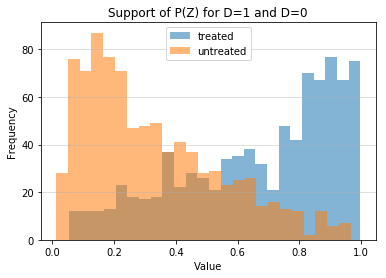

In [8]:
pyplot.hist(treated['ps'], bins=25, alpha=0.55, label='treated', density=False)
pyplot.hist(untreated['ps'], bins=25, alpha=0.55, label='untreated', density=False)
pyplot.legend(loc='upper center')
pyplot.grid(axis='y', alpha=0.5)
pyplot.xlabel('Value')
pyplot.ylabel('Frequency')
pyplot.title('Support of P(Z) for D=1 and D=0')
pyplot.show()

In [9]:
# Common support
print(np.max(untreated['ps']))
print(np.min(treated['ps']))

0.9670786072336038
0.053615848983571426


Carneiro et al. (2011) find common support between 0.0324 and 0.9775.

An alternative, as suggested by Heckman (2006), would be to use a set $\mathcal{P}$ of prespecified evaluation points. In this case, in order to compute the predicted value of $X_k$ for each individual, it would be necessary to replace her value of the predicted propensity score by the closest value in $\mathcal{P}$.

In [10]:
# Trim the data
df_trim = df[(df.ps >= np.min(treated['ps'])) & (df.ps <= np.max(untreated['ps']))]
ps_trim = ps[(ps >= np.min(treated['ps'])) & (ps <= np.max(untreated['ps']))]

## $\mathrm{3)}$ Double Residual Regression

*LOESS (Locally Estimated Scatterplot Smoothing)* and *LOWESS (Locally Weighted Scatterplot Smoothing)* are the two most common methods of local regression or, equivalently called, local polynomial regression.
Because of their poularity, packages for the implementation of loess and lowess are available for the majority of programming languages out there. Statsmodels provides a lowess function for Python:

https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

The function defined in the following utilizes the statsmodels package *lowess* for the implementation of a double residual regression procedure ([Robinson, 1988](https://www.jstor.org/stable/1912705?seq=1#page_scan_tab_contents)). In order to do so, we start by fitting a local linear regression of each regressor in equation (1) on the predicted propensity score $\hat{P}(z)$. Note that

$$E(Y |X = x, P(Z) = p) = \alpha + \beta_0 x + ((\beta_1 - \beta_0) x) p + K(p) \ \ \ \mathrm{(1)}$$

also contains terms of the form $X_k \hat{P}(z) \ := \ X \ \mathrm{x} \ p$ for our $k = 1,...,n_X$ regressors. Hence, we need to estimate $2$  x $n_X$ local linear regressions, i.e. $n_X$ regressions of $X$ on $\hat{P}(z)$ and another $n_X$ times of $X$ x $p$ on $\hat{P}(z)$. We store the predicted value of $X_k$ for each column $k$ and each individual $j$, denoted by $\hat{X}_k (j)$, and compute its residual:

$$e_{X_k} = X_k(j) \ - \ \hat{X}_k (j)$$

Analogously, we repeat this exercise $n_X$ times for all $X$ x $p$ variables.

We also need to estimate a local linear regression of $Y$ on $\hat{P}(z)$ and generate the residual associated with outcome $Y$ for each person $j$:

$$e_{Y} = Y(j) \ - \ \hat{Y} (j)$$

Local linear regressions for these three sets of variables yield residuals $e_x$, $e_{X \ \mathrm{x} \ P}$ and $e_Y$.

### $\mathrm{3a)}$ Fit *local linear regressions* of $X$, $X$ x $p$ and $Y$ on $\hat{P}(z)$

First, sort the trimmed data by the propensity score. This step is necessary because *statsmodels's* lowess function requires the input variables to be sorted by the independent variable, here $\hat{P}(z)$. 

In [11]:
df_trim = df_trim.sort_values(by='ps', ascending=True)
ps_trim = np.sort(ps_trim)

Select regressors $X$.

In [12]:
X_trim = df_trim[['const',
'exp', 
'expsq', 
'lwage5', 
'lurate', 
'cafqt', 
'cafqtsq', 
'mhgc', 
'mhgcsq', 
'numsibs', 
'numsibssq', 
'urban14', 
'lavlocwage17', 
'lavlocwage17sq', 
'avurate', 
'avuratesq', 
'd57', 
'd58', 
'd59', 
'd60', 
'd61', 
'd62', 
'd63']]

In [13]:
X_trim.reset_index(drop=True, inplace=True)

Construct regressor $X_k \hat{P}(z) \ := \ X \ \mathrm{x} \ p \$

In [14]:
# Set up a N x k matix where each column contains the elements of the sorted N x 1 propensity score
N = len(X_trim)
ps_trim = pd.Series(ps_trim)
P_z = pd.concat([ps_trim]*len(X_trim.columns), axis=1, ignore_index=True)

# Construct Xp
Xp_trim = pd.DataFrame(X_trim.values*P_z.values, columns=[key_ + "_ps" for key_ in list(X_trim)], index=X_trim.index)

Define function to calculate lowess residuals.

In [15]:
lowess = sm.nonparametric.lowess

In [16]:
def lowess_residuals(ydata, xdata, bw, it_):
    """ This function implements a lowess regression of ydata on xdata and computes 
    the corresponding y residuals.
    
    frac: The fraction of the data, i.e. bandwidth, used when estimating each y-value.
    it_: The number of residual-based reweightings to perform.
    """

    # Turn input data into np arrays
    ydata = np.array(ydata)
    xdata = np.array(xdata)
        
    # Determine number observations and number of columns
    N = len(ydata)
    col_len = len(ydata[0])
    
    # Lowess function to obtain fitted values for ydata. These are contained 
    # in the second column of the 2D array generated by the lowess function.
    y_fit = np.zeros([N, col_len])
        
    for i in range(col_len):
        y_fit[:, i] = lowess(ydata[:, i], xdata, frac=bw, it=it_, is_sorted=True)[:,1]
        
        
    # Compute residuals by subtracting the fitted values from the actual values
    res = np.zeros([N, col_len])
                 
    for i in range(col_len):
        res[:, i] = ydata[:, i] - y_fit[:, i]
                 
    return res

Now, use this function and compute the lowess residuals of $X$, $X$ x $p$ and $Y$. Following Carneiro et al. (2011), choose a bandwidth of 0.05.

In [17]:
#%%time
res_X = lowess_residuals(X_trim, ps_trim, 0.05, 1)
res_Xp = lowess_residuals(Xp_trim, ps_trim, 0.05, 1)
res_Y = lowess_residuals(df_trim[['wage']], ps_trim, 0.05, 1)

In [18]:
# Append res_X and res_Xp. Turn resulting array into a data frame to have the variable names 
# displayed in the output table.
col_names = list(X_trim) + list(Xp_trim)
res_X_Xp = pd.DataFrame(np.append(res_X, res_Xp, axis=1), columns=col_names)

### $\mathrm{3b)}$ Estimate $\beta_0$ and $(\beta_1 - \beta_0)$ via OLS

$$ e_Y =e_X \beta_0 \ + \ e_{X \ \mathrm{x} \ P} (\beta_1 - \beta_0) \ + \ \epsilon $$

In [19]:
model = sm.OLS(res_Y, res_X_Xp)
results = model.fit()
b1 = results.params[:len(list(X_trim))]
b1_b0 = results.params[len((list(X_trim))):]

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     2.822
Date:                Tue, 18 Jun 2019   Prob (F-statistic):           3.87e-09
Time:                        17:07:04   Log-Likelihood:                -987.20
No. Observations:                1659   AIC:                             2062.
Df Residuals:                    1615   BIC:                             2301.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.111e-11   1.43e-1

Note that size and significance level of the estimated coefficients varies heavily with the number of iterations chosen, but the final *MTE* plots look similar (see below). 

## $\mathrm{4)}$ Construct $\tilde{Y}$

After obtaining the estimated values of ($\beta_1 - \beta_0$), only $\frac{\partial K(p)}{\partial p}$ remains to be estimated. To do this we rewrite equation $\mathrm{(1)}$ to get 

$$\tilde{Y} = K(p) + \epsilon ,$$

where $\tilde{Y} = Y - X' \widehat{\beta_0} - X' (\widehat{\beta_1 - \beta_0}) p$. The second and third elements of the right hand side capture the observed part of the heterogeneity in $Y$. <br>
Hence, $\tilde{Y}$ is the residual that captures the heterogeneity along the unobserved component $K(p)$.

In [20]:
# Prepare arrays
ps_arr = np.array(ps_trim)
X_arr = np.array(X_trim)
Xp_arr = np.array(Xp_trim)
Y_arr = df_trim['wage']

# Construct the unobserved part of Y
Y_tilde = Y_arr - np.dot(X_arr, b1) - np.dot(Xp_arr, b1_b0)

## $\mathrm{5)}$ Estimate $\frac{\partial K}{\partial p}$ through a locally quadratic regression

$\frac{\partial K}{\partial p}$ is the first derivative of a local polynomial regression of $\tilde{Y}$ on $\hat{P}(z)$. 
This is the component of the *MTE* formula that depends on the unobserved resistance to treatment $u_D$.
[Fan and Gijbels (1996)](https://www.amazon.com/Local-Polynomial-Modelling-Its-Applications/dp/0412983214) suggest that the order $n$ of the polynomial be equal to $\pi = \tau + 1$, where $\tau$ is the order of the derivative of the function of interest to be fitted. That is, Fan and Gijbels recommend a local linear estimator for fitting a function and a local quadratic estimator for fitting a first-order derivative. Therefore, Carneiro et al. (2011) use a local quadratic estimator of $\frac{\partial K}{\partial p}$. <br>
They choose the bandwidth that minimizes the residual square criterion proposed in Fan and Gijbels, which yields a bandwidth of 0.322.

Unfortunately, there is currently no Python package out there that can fit a locally quadratic regression. 
Statsmodels's Kernel Regression can only implement local polynomials up to degree 1 (https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.kernel_regression.KernelReg.html). <br>

Thus, we load R's **KernSmooth package** via Rpy2. We will use the function **locpoly** to estimate a local polynomial regression of order 2 (https://www.rdocumentation.org/packages/KernSmooth/versions/2.23-15/topics/locpoly).

In [21]:
%load_ext rpy2.ipython

In [22]:
# Import the relevant variables for the locally quadratic estimation of K(p)
%R -i Y_tilde
%R -i ps_arr
%R Y_tilde <- as.matrix(Y_tilde)
%R ps_arr <- as.matrix(ps_arr)

# Set drv = 1L to estimate the first derivative.
%R mte_u_poly <- locpoly(ps_arr, Y_tilde, drv = 1L, degree=2, bandwidth = 0.322, gridsize=500L, range.x = c(0.005, 0.995))

R object with classes: ('list',) mapped to:
<ListVector - Python:0x1c3103afc8 / R:0x7f9b2cc9bc88>
[FloatVector, FloatVector]
  x: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x1c3103ae48 / R:0x7f9b25ed9a00>
[0.005000, 0.006984, 0.008968, 0.010952, ..., 0.989048, 0.991032, 0.993016, 0.995000]
  y: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x1c2fdc8108 / R:0x7f9b26999600>
[-78.117464, -78.123513, -78.129544, -78.135557, ..., -79.623212, -79.622918, -79.622599, -79.622255]

Use 500 equally spaced evaluation points within the common support of 0.0536 and 0.9671.
By setting *range.x* to (0.005, 0.995) $\frac{\partial K}{\partial p}$ is additionally estimated for values of $P(z)$ outside the common support. This way we can fully compare our replicated results to the original ones from Figure 4 in Carneiro et al. (2011) who have common support between 0.0324 and 0.9775 but plot marginal treatment effects in the full range from 0 to 1 as well.

Note that extending the set of evaluation points to values outside the common support does not alter the estimates for $\frac{\partial K}{\partial p}$ within the range of our data.

In [24]:
# Return mte_u, the component that depends on the derivative of K(p) evaluated at p=u, 
# as well as the quantiles of p=u as data frames and export them back into Python.
%R mte_u <- mte_u_poly$y
%R mte_u <- data.frame(mte_u)
%R quantiles_u <- mte_u_poly$x
%R quantiles <- data.frame(quantiles_u)

%R -o mte_u
%R -o quantiles

## $\mathrm{6)}$ Construct *MTE*

Recall the *MTE* formula:

$$\Delta^{MTE} (x, u_D) \ = \ x' (\beta_1 - \beta_0) + \frac{\partial K(p)}{\partial p} \ \bigg\rvert_{p = u_D}$$

Calculate the *MTE* component that depends on $X$.

In [25]:
mte_x = np.dot(X_trim, b1_b0).mean(axis=0)

Put the MTE together.

In [26]:
mte = mte_x + mte_u

The MTE just calculated refers to the benefits of obtaining a 4 year college degree.
To get an estimate of the benefits of one additional year of college education divide the *MTE* by four.

In [27]:
mte_4 = mte/4

# Robustness

As one source of variability in this setup certainly stems from the construction of residuals in the double residual regression procedure described in section $\mathrm{3a)}$, I compute the *MTE* for two alternative specifications. First, I use 10 iterations. Second, I utilize the *R function loess* to calculate the residuals. <br>
Note that R's *loess* function does not come with an option specifying the number of iterations, i.e. residual-based reweightings to perform. 

### Choose 10 lowess iterations

In [28]:
# Compute the lowess residuals of X, Xp and Y
res_X_10 = lowess_residuals(X_trim, ps_trim, 0.05, 10)
res_Xp_10 = lowess_residuals(Xp_trim, ps_trim, 0.05, 10)
res_Y_10 = lowess_residuals(df_trim[['wage']], ps_trim, 0.05, 10)

res_X_Xp_10 = np.append(res_X_10, res_Xp_10, axis=1)

model_10 = sm.OLS(res_Y_10, res_X_Xp_10)
results_10 = model_10.fit()
b1_10 = results_10.params[:len(list(X_trim))]
b1_b0_10 = results_10.params[len((list(X_trim))):]

# prepare arrays
ps_arr_10 = np.array(ps_trim)
X_arr_10 = np.array(X_trim)
Xp_arr_10 = np.array(Xp_trim)
Y_arr_10 = df_trim['wage']

# compute the unobserved part of Y
Y_tilde_10 = Y_arr_10 - np.dot(X_arr_10, b1_10) - np.dot(Xp_arr_10, b1_b0_10)
        
%reload_ext rpy2.ipython
    
%R -i Y_tilde_10
%R -i ps_arr_10
%R Y_tilde_10 <- as.matrix(Y_tilde_10)
%R ps_arr_10 <- as.matrix(ps_arr_10)

%R mte_u_poly_10 <- locpoly(ps_arr_10, Y_tilde_10, drv = 1L, degree=2, bandwidth = 0.322, gridsize = 500L, range.x = c(0.005, 0.995))

# Return the mte_u component and the quantiles of u_D as data frames and export them back into Python.
%R mte_u_10 <- mte_u_poly_10$y
%R mte_u_10 <- data.frame(mte_u_10)
%R quantiles_10 <- mte_u_poly_10$x
%R quantiles_10 <- data.frame(quantiles_10)

%R -o mte_u_10
%R -o quantiles_10
    
mte_x_10 = np.dot(X_trim, b1_b0_10).mean(axis=0)
mte_10 = mte_x_10 + mte_u_10
    
# Annulaize mte
mte_4_10 = mte_10/4

### Use R's loess function to compute residuals

In [29]:
# Define Y_trim
Y_trim = df_trim[['wage']]
    
%reload_ext rpy2.ipython
        
%R -i X_trim
%R -i Xp_trim
%R -i Y_trim
%R -i ps_trim

%R X <- as.matrix(X_trim)
%R Xp <- as.matrix(Xp_trim)
%R Y <- as.matrix(Y_trim)
%R ps <- as.matrix(ps_trim)

# Compute the lowess residuals of X, Xp and Y    
%R res_Y_R <- loess(Y ~ ps, span = 0.05, degree = 1)$res
%R res_X_R <- apply(X, 2, function(x) loess(x ~ ps, span = 0.05, degree = 1)$res)
%R res_Xp_R <- apply(Xp, 2, function(x) loess(x ~ ps, span = 0.05, degree = 1)$res)

%R res_Y_R <- data.frame(res_Y_R)
%R res_X_R <- data.frame(res_X_R)
%R res_Xp_R <- data.frame(res_Xp_R)

%R -o res_Y_R
%R -o res_X_R
%R -o res_Xp_R

# Append res_X and res_Xp. 
res_X_Xp_R = np.append(res_X_R, res_Xp_R, axis=1)

model_R = sm.OLS(res_Y_R, res_X_Xp_R)
results_R = model_R.fit()
b1_R = results_R.params[:len(list(X_trim))]
b1_b0_R = results_R.params[len((list(X_trim))):]

# prepare arrays
ps_arr_R = np.array(ps_trim)
X_arr_R = np.array(X_trim)
Xp_arr_R = np.array(Xp_trim)
Y_arr_R = df_trim['wage']

# compute the unobserved part of Y
Y_tilde_R = Y_arr_R - np.dot(X_arr_R, b1_R) - np.dot(Xp_arr_R, b1_b0_R)
        
%reload_ext rpy2.ipython
    
%R -i Y_tilde_R
%R -i ps_arr_R
%R Y_tilde_R <- as.matrix(Y_tilde_R)
%R ps_arr_R <- as.matrix(ps_arr_R)

%R mte_u_poly_R <- locpoly(ps_arr_R, Y_tilde_R, drv = 1L, degree=2, bandwidth = 0.322, gridsize = 500L, range.x = c(0.005, 0.995))

# Return the mte_u component and the quantiles of u_D as data frames and export them back into Python.
%R mte_u_R <- mte_u_poly_R$y
%R mte_u_R <- data.frame(mte_u_R)
%R quantiles_R <- mte_u_poly_R$x
%R quantiles_R <- data.frame(quantiles_R)

%R -o mte_u_R
%R -o quantiles_R
    
mte_x_R = np.dot(X_trim, b1_b0_R).mean(axis=0)
mte_R = mte_x_R + mte_u_R
    
# Annulaize mte
mte_4_R = mte_R/4

## Bootstrap standard errors and compute 90% confidence intervals  

Following in Carneiro et al. (2011), bootstrapped standard errors are used to compute 90 percent confidence intervals (250 iterations). To keep this notebook concise, the bootstrapping is done in another notebook. The estimates for the bootstrapped standard errors are stored and imported below. With every iteration of the bootstrap, $\hat{P}(z)$ is reestimated, too, so the evaluation points $u_D$ over which to compute the *MTE* vary with each iteration. Carneiro et al. (2011) don't mention how they deal with this circumstance, so I simply compute the mean for each row of the 500 points that are reproduced with each bootstrap. The means for the bootstrapped quantiles $u_D$ are imported below as well.

First, draw $B = 250$ independent bootstrap samples and compute the *MTE* $ \ \hat{\theta}^{MTE}(b)$ for each bootstrap replication $b = 1,..,B$, where $B$ is the number of bootstrap samples used. Second, estimate the standard error of $\hat{\theta}^{MTE}$, denoted by $\widehat{\mathbf{se}}_B$, separately for each gridpoint $u_D$:

$$ \widehat{\mathbf{se}}_B = \frac{1}{B-1} \sum_{b = 1}^{B}{\{ \hat{\theta}}^{MTE}(b) \ - \ \hat{\theta}^{MTE}(\cdot)    \}^2 $$

where $\hat{\theta}^{MTE}(\cdot) = B^{-1} \sum_{b = 1}^{B}{ \hat{\theta}}^{MTE}(b)$.

In [30]:
se_R = pd.read_csv('se_R.csv').iloc[:,1]
u_R_mean = pd.read_csv('quantiles_R_mean.csv').iloc[:,1]

In [31]:
# Compute 90 percent confidence intervals
con_R_u = mte_4_R.iloc[:,0] + norm.ppf(0.95) * se_R
con_R_d = mte_4_R.iloc[:,0] - norm.ppf(0.95) * se_R

Plot the replicated MTE results vis-à-vis the original ones. The original results were obtained by digitizing Figure 4 from Carneiro et al. (2011) with the software [*Engauge Digitizer*](https://apps.apple.com/us/app/engauge-digitizer/id1107356098?mt=12).

In [32]:
# import original results
mte_ = pd.read_csv('data/mte_semipar_original.csv')

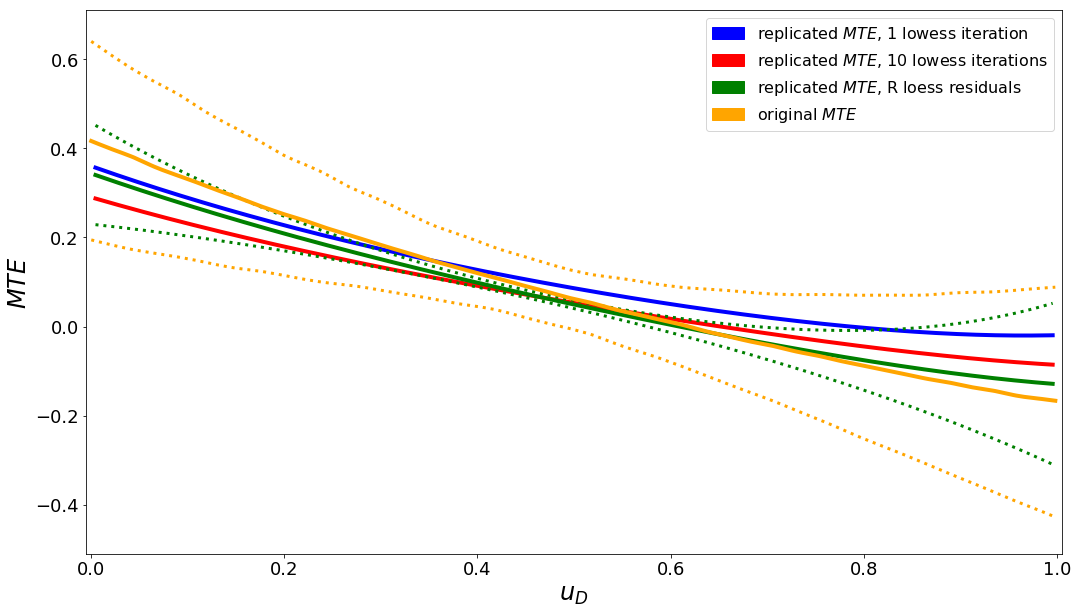

In [33]:
ax = plt.figure(figsize=(17.5, 10)).add_subplot(111)

ax.set_ylabel(r"$MTE$", fontsize=24)
ax.set_xlabel("$u_D$", fontsize=24)
ax.tick_params(axis="both", which="major", labelsize=18)

# Plot replicated curves
ax.plot(quantiles, mte_4, label="replicated $MTE$, 1 lowess iteration", color="blue", linewidth=4)

ax.plot(quantiles_10, mte_4_10, label="replicated $MTE$, 10 lowess iterations", color="red", linewidth=4)

ax.plot(quantiles_R, mte_4_R, label="replicated $MTE$, R loess residuals", color="green", linewidth=4)
ax.plot(u_R_mean, con_R_u, color="green", linestyle=":", linewidth=3)
ax.plot(u_R_mean, con_R_d, color="green", linestyle=":", linewidth=3)


# Plot original curve
ax.plot(mte_['quantiles'], mte_['mte'], label="$original MTE$", color="orange", linewidth=4)
ax.plot(mte_['quantiles'], mte_['con_u'], color="orange", linestyle=":", linewidth=3)
ax.plot(mte_['quantiles'], mte_['con_d'], color="orange", linestyle=":", linewidth=3)

ax.set_ylim([-0.51, 0.71])
ax.set_xlim([-0.005, 1.005])

blue_patch = mpatches.Patch(color="blue", label="replicated $MTE$, 1 lowess iteration")
red_patch = mpatches.Patch(color="red", label="replicated $MTE$, 10 lowess iterations")
green_patch = mpatches.Patch(color="green", label="replicated $MTE$, R loess residuals")

orange_patch = mpatches.Patch(color="orange", label="original $MTE$")
plt.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], prop={"size": 16})
plt.show()

As the graph shows, the curves of the replicated *MTEs* definitely go in the direction of the original *MTE* but are flatter on the margins, especially the ones utilizing statsmodels' lowess function. The blue and the green curve look similar in slope with the difference that the red curve (10 lowess iterations) is shifted downwards. The specification using residuals from R's loess - green line - seems to come closest to the original curve. Compared to the original plot, the 90 percent confidence bands are too tight, particularly in the mid section of $u_D$. In the graph above, only the confidence bands for the R specification are shown (green dotted line). Confidence bands centered at the blue curve look similar, but are omitted for sake of clarity (standard errors for 10 lowess iterations could not be computed, as the bootstrap algorithm breaks down).

The deviations might be due to the use of a mock data set combined with the utilization of nonparametric techniques which makes the semiparametric replication more sensitive compared to a parametric specification.